# JSSP comparação entre euristicas Classicas: tratamento dos dados 

In [56]:
# %pip install pandas
# %pip install seaborn
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib.util
import os

# Recarregar módulos para pegar alterações
import importlib
import sys
if 'classes.jssp' in sys.modules:
    importlib.reload(sys.modules['classes.jssp'])
if 'classes.job' in sys.modules:
    importlib.reload(sys.modules['classes.job'])
if 'classes.operation' in sys.modules:
    importlib.reload(sys.modules['classes.operation'])

from classes.jssp import jssp
from classes.job import Jssp_job
from classes.operation import Operation

ARCHIVE = "best"

In [58]:
def import_tests_cases(nome_dict : str) -> dict:

    caminho_absoluto = os.path.abspath("../tests/test1.py")

    spec = importlib.util.spec_from_file_location("modulo_temp", caminho_absoluto)
    
    if spec is None or spec.loader is None:
        raise ImportError(f"Não foi possível carregar o módulo do arquivo: {caminho_absoluto}")
    
    modulo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(modulo)

    return getattr(modulo, nome_dict)
csv_filename = "simulated_annealing_results.csv"
df = pd.read_csv(csv_filename)
print(df.columns)

def simulate_schedule(solution_vec, operations):
    order = np.argsort(solution_vec)
    machine_available = {}
    job_available = {}
    schedule = []

    for idx in order:
        op = operations[idx]
        job = op["job"]
        machine = min(op["machines"], key=lambda m: machine_available.get(m, 0))

        start_time = max(machine_available.get(machine, 0), job_available.get(job, 0))
        end_time = start_time + op["duration"]

        machine_available[machine] = end_time
        job_available[job] = end_time

        schedule.append({
            "job": job,
            "machine": machine,
            "start": start_time,
            "end": end_time,
            "duration": op["duration"],
            "op_index": idx,
            "operation_id": op.get("operation_id", "N/A")  # Adicionar ID da operação
        })

    return schedule

def plot_gantt(schedule):
    machines = sorted(set(op['machine'] for op in schedule))
    machine_to_y = {m: i for i, m in enumerate(machines)}

    # Criar cores diferentes para cada job
    unique_jobs = sorted(set(op['job'] for op in schedule))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_jobs)))
    job_colors = {job: colors[i] for i, job in enumerate(unique_jobs)}

    fig, ax = plt.subplots(figsize=(12, 8))

    for op in schedule:
        start = op["start"]
        duration = op["duration"]
        machine = op["machine"]
        y = machine_to_y[machine]
        job = op["job"]
        op_id = op["operation_id"]

        # Usar cor específica para cada job
        color = job_colors[job]
        
        ax.barh(y, duration, left=start, height=0.6, align='center', 
                color=color, edgecolor='black', linewidth=1.5)

        # Mostrar job e ID da operação
        label = f"{job}\nOp:{op_id}"
        ax.text(start + duration / 2, y, label, 
                va='center', ha='center', color='black', fontsize=12, fontweight='bold')

    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels([f"Máquina {m}" for m in machines])
    ax.set_xlabel("Tempo", fontsize=12)
    ax.set_ylabel("Máquinas", fontsize=12)
    ax.set_title("Gráfico de Gantt - Escalonamento JSSP\n(Job + ID da Operação)", fontsize=14, fontweight='bold')

    # Adicionar grid para melhor visualização
    plt.grid(True, axis='x', alpha=0.7)
    plt.grid(True, axis='y', alpha=0.3)
    
    # Adicionar legenda para os jobs
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=job_colors[job], 
                                   edgecolor='black', label=job) for job in unique_jobs]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()

    # Imprimir informações detalhadas do cronograma para verificação das restrições
    print("\n" + "="*80)
    print("DETALHES DO CRONOGRAMA PARA VERIFICAÇÃO DE RESTRIÇÕES")
    print("="*80)
    
    # Ordenar por tempo de início para melhor visualização
    schedule_sorted = sorted(schedule, key=lambda x: x['start'])
    
    for op in schedule_sorted:
        print(f"Job: {op['job']:<8} | Op: {op['operation_id']:<3} | Máquina: {op['machine']:<3} | "
              f"Início: {op['start']:<6.2f} | Fim: {op['end']:<6.2f} | Duração: {op['duration']}")
    
    print("\n" + "="*60)
    print("VERIFICAÇÃO DE RESTRIÇÕES POR JOB")
    print("="*60)
    
    # Verificar ordem das operações por job
    job_operations = {}
    for op in schedule_sorted:
        job = op['job']
        if job not in job_operations:
            job_operations[job] = []
        job_operations[job].append(op)
    
    for job, ops in job_operations.items():
        print(f"\n{job}:")
        ops_sorted = sorted(ops, key=lambda x: x['start'])
        for i, op in enumerate(ops_sorted):
            print(f"  {i+1}ª operação: Op {op['operation_id']} na Máquina {op['machine']} "
                  f"(Início: {op['start']:.2f}, Fim: {op['end']:.2f})")
            
            # Verificar se há sobreposição com operação anterior do mesmo job
            if i > 0:
                prev_op = ops_sorted[i-1]
                if op['start'] < prev_op['end']:
                    print(f"    ⚠️  VIOLAÇÃO: Operação iniciou antes da anterior terminar!")
                else:
                    print(f"    ✅ OK: Respeitou precedência ({prev_op['end']:.2f} → {op['start']:.2f})")



Index(['id', 'execution_time', 'fitness', 'timespan', 'solution_vector'], dtype='object')


In [59]:
# Comparação entre timespan e fitness em porcentagem
print(f"\n{'='*50}")
print("COMPARAÇÃO TIMESPAN vs FITNESS (em %)")
print(f"{'='*50}")

timespan_ref = df['timespan'].iloc[0]
melhor_fitness = df['fitness'].min()
fitness_medio = df['fitness'].mean()
pior_fitness = df['fitness'].max()

print(f"Timespan de referência: {timespan_ref}")
print(f"\nAnálise do MELHOR fitness:")
print(f"Melhor fitness: {melhor_fitness:.2f}")
if timespan_ref > 0:
    diff_melhor = ((melhor_fitness - timespan_ref) / timespan_ref) * 100
    if diff_melhor <= 0:
        print(f"{abs(diff_melhor):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_melhor:.2f}% PIOR que o timespan de referência")

print(f"\nAnálise do FITNESS MÉDIO:")
print(f"Fitness médio: {fitness_medio:.2f}")
if timespan_ref > 0:
    diff_medio = ((fitness_medio - timespan_ref) / timespan_ref) * 100
    if diff_medio <= 0:
        print(f"{abs(diff_medio):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_medio:.2f}% PIOR que o timespan de referência")

print(f"\nAnálise do PIOR fitness:")
print(f"Pior fitness: {pior_fitness:.2f}")
if timespan_ref > 0:
    diff_pior = ((pior_fitness - timespan_ref) / timespan_ref) * 100
    if diff_pior <= 0:
        print(f"{abs(diff_pior):.2f}% MELHOR que o timespan de referência")
    else:
        print(f"{diff_pior:.2f}% PIOR que o timespan de referência")

# Estatísticas adicionais
print(f"\n{'='*50}")
print("ESTATÍSTICAS GERAIS")
print(f"{'='*50}")
execucoes_melhores = len(df[df['fitness'] <= timespan_ref])
total_execucoes = len(df)
porcentagem_melhores = (execucoes_melhores / total_execucoes) * 100

print(f"Execuções que atingiram/superaram o timespan: {execucoes_melhores}/{total_execucoes} ({porcentagem_melhores:.1f}%)")

# Distribuição de performance
fitness_values = df['fitness'].values
melhorias = []
for fitness in fitness_values:
    if timespan_ref > 0:
        melhoria = ((fitness - timespan_ref) / timespan_ref) * 100
        melhorias.append(melhoria)

melhorias = np.array(melhorias)
print(f"Melhoria média: {melhorias.mean():.3f}%")
print(f"Desvio padrão das melhorias: {melhorias.std():.3f}%")


COMPARAÇÃO TIMESPAN vs FITNESS (em %)
Timespan de referência: 2

Análise do MELHOR fitness:
Melhor fitness: 2.00
0.00% MELHOR que o timespan de referência

Análise do FITNESS MÉDIO:
Fitness médio: 135.33
6666.67% PIOR que o timespan de referência

Análise do PIOR fitness:
Pior fitness: 1002.00
50000.00% PIOR que o timespan de referência

ESTATÍSTICAS GERAIS
Execuções que atingiram/superaram o timespan: 26/30 (86.7%)
Melhoria média: 6666.667%
Desvio padrão das melhorias: 16996.732%


=== DEBUG: Operações carregadas ===
Operação 0: {'machines': [1, 2], 'equipments': [], 'duration': 1, 'operation_id': 1, 'job': 'job_1'}
Operação 1: {'machines': [1, 2], 'equipments': [], 'duration': 1, 'operation_id': 2, 'job': 'job_1'}
Operação 2: {'machines': [1, 2], 'equipments': [], 'duration': 1, 'operation_id': 1, 'job': 'job_2'}
Operação 3: {'machines': [1, 2], 'equipments': [], 'duration': 1, 'operation_id': 2, 'job': 'job_2'}

=== DEBUG: Jobs e suas operações ===
Job: job_1
  Operação 1: ID=1, Machines=[1, 2], Duration=1
  Operação 2: ID=2, Machines=[1, 2], Duration=1
Job: job_2
  Operação 1: ID=1, Machines=[1, 2], Duration=1
  Operação 2: ID=2, Machines=[1, 2], Duration=1

=== Melhor solução ===
id                                                            107915
execution_time                                              0.042169
fitness                                                          2.0
timespan                                                           2
solution

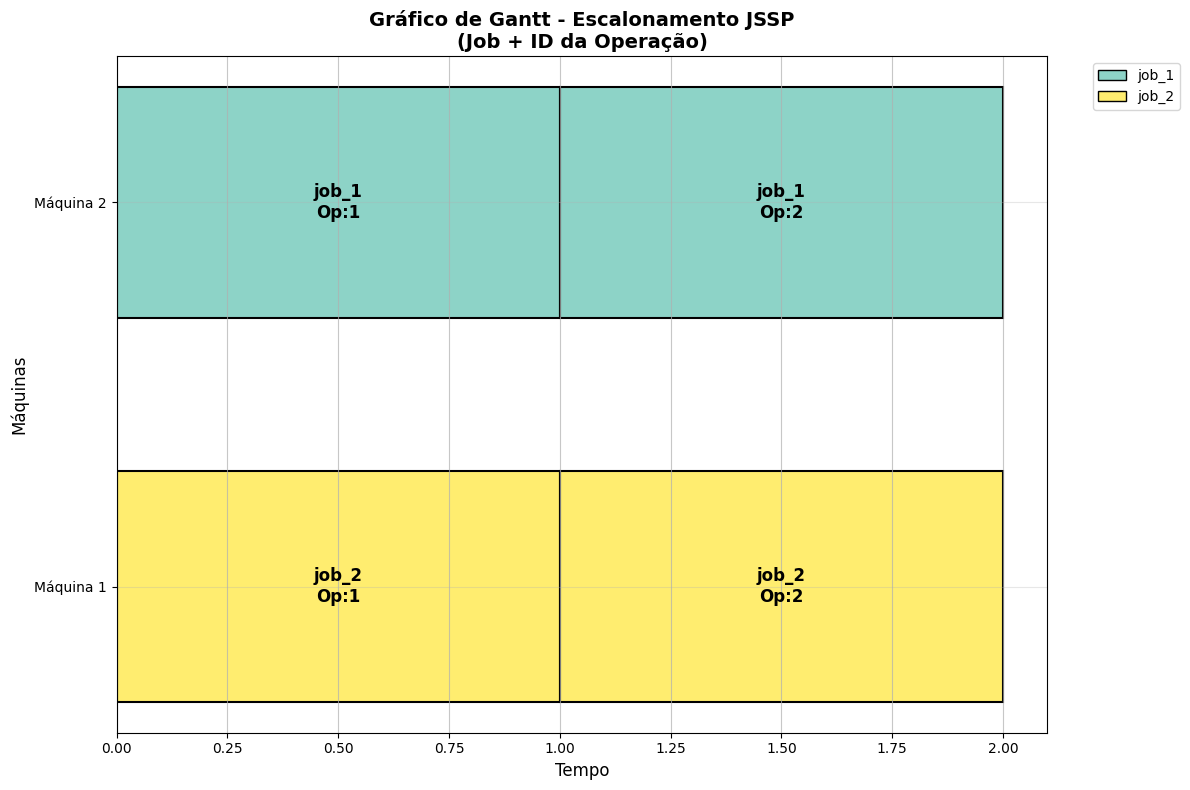


DETALHES DO CRONOGRAMA PARA VERIFICAÇÃO DE RESTRIÇÕES
Job: job_2    | Op: 1   | Máquina: 1   | Início: 0.00   | Fim: 1.00   | Duração: 1
Job: job_1    | Op: 1   | Máquina: 2   | Início: 0.00   | Fim: 1.00   | Duração: 1
Job: job_2    | Op: 2   | Máquina: 1   | Início: 1.00   | Fim: 2.00   | Duração: 1
Job: job_1    | Op: 2   | Máquina: 2   | Início: 1.00   | Fim: 2.00   | Duração: 1

VERIFICAÇÃO DE RESTRIÇÕES POR JOB

job_2:
  1ª operação: Op 1 na Máquina 1 (Início: 0.00, Fim: 1.00)
  2ª operação: Op 2 na Máquina 1 (Início: 1.00, Fim: 2.00)
    ✅ OK: Respeitou precedência (1.00 → 1.00)

job_1:
  1ª operação: Op 1 na Máquina 2 (Início: 0.00, Fim: 1.00)
  2ª operação: Op 2 na Máquina 2 (Início: 1.00, Fim: 2.00)
    ✅ OK: Respeitou precedência (1.00 → 1.00)


In [60]:
data = import_tests_cases(ARCHIVE)
jssp_instance = jssp(data)

# Debug: verificar as operações carregadas
print("=== DEBUG: Operações carregadas ===")
operations = jssp_instance.get_flattened_operations()
for i, op in enumerate(operations):
    print(f"Operação {i}: {op}")

print("\n=== DEBUG: Jobs e suas operações ===")
for job in jssp_instance.jobs:
    print(f"Job: {job.name}")
    for i, operation in enumerate(job.operations):
        print(f"  Operação {i+1}: ID={operation.id}, Machines={operation.machines}, Duration={operation.duration}")

best_solution = df[df['fitness'] == df['fitness'].min()].iloc[1]
print(f"\n=== Melhor solução ===")
print(best_solution)
a = best_solution["solution_vector"]
a = a.replace(" ", "")
a = a.replace("[", "")
a = a.replace("]", "")
a = a.split(",")

print(f"Melhor solução encontrada: {(a)}")
schedule = simulate_schedule(a, jssp_instance.get_flattened_operations())
plot_gantt(schedule)